___

## Dense Neural Networks
#### DJ Dawkins, Nathan Deinlein, Joseph Lazarus, and Puri Rudick​

DS7333 QTW: Case Study 6
___

### Buisness Understanding
The goal for this case study is to build a classification model using a dense neural network to distinguish between a signal process which produces Higgs bosons and a background process which does not.

The goal is to maximize the accuracy and describe the decisions made while designing and building the network as well as determining when the model has sufficiently finished training. 

### Data Evaluation/Engineering

There are 7 million records and 29 features (including the target feature), and there were no missing values.<br>
The target is binary, the classes are balanced with the positve target value having a prevlaence of ~50%.<br>
<br><br>
Most of the features tend to be continous and take on either a normal-ish distribution or a uniform distribution, six of the features look to be categorical.<br>
For features f0, f3, f6, f10, f14, f18, and f26 the pos. and neg. populations appear to take on noticiably different shapes.<br>
Feature f0 values for both pos and neg are predominantly 0.<br>
No evience of correlation was found amongst any of the features.<br>

#### Imports

In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#### Read data from zip

In [48]:
# The file is 1.63GB, which is too big for Github
# Save the file locally and read in using the file's path

# path = 'C:/Users/puri.rudick/Downloads/all_train.csv.gz'
# path = '/Users/puri/DataScience@SMU/10.DS7333 QTW/all_train.csv.gz'
path = "C:/Users/OaklandHillsMansion/OneDrive - Southern Methodist University/SMU/DS 7333 Quantify World/QTW_Week11_Files/all_train.csv.gz"

df = pd.read_csv(path, compression='gzip', on_bad_lines='skip')

In [50]:
df.shape

(7000000, 29)

In [51]:
df.describe()

,# label,f0,f1,f2,f3,f4,f5,f6,f7,f8,...,f18,f19,f20,f21,f22,f23,f24,f25,f26,mass
count,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,...,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06,7.000000e+06
mean,5.001256e-01,1.612528e-02,4.770022e-04,2.686578e-05,1.056081e-02,-1.050026e-04,2.765919e-03,1.815953e-02,2.510948e-05,4.345870e-04,...,1.164789e-02,-1.127097e-04,7.686731e-05,2.909202e-04,1.228774e-02,9.778378e-03,5.269844e-03,-1.760961e-03,1.533136e-02,1.000107e+03
std,5.000000e-01,1.004417e+00,9.974864e-01,1.000080e+00,9.956003e-01,9.998670e-01,1.000957e+00,9.867746e-01,9.965867e-01,1.000007e+00,...,1.002725e+00,1.000038e+00,1.000033e+00,1.000170e+00,1.010477e+00,1.005418e+00,1.009990e+00,9.844511e-01,9.822799e-01,3.534255e+02
min,0.000000e+00,-1.960549e+00,-2.365355e+00,-1.732165e+00,-9.980274e+00,-1.732137e+00,-1.054221e+00,-3.034787e+00,-2.757853e+00,-1.732359e+00,...,-1.728284e+00,-2.281867e+00,-1.731758e+00,-5.736825e-01,-3.631608e+00,-4.729473e+00,-2.062223e+01,-3.452634e+00,-2.632761e+00,5.000000e+02
25%,0.000000e+00,-7.288206e-01,-7.332548e-01,-8.656704e-01,-6.092291e-01,-8.658025e-01,-1.054221e+00,-7.566092e-01,-7.014146e-01,-8.656543e-01,...,-7.423630e-01,-7.206846e-01,-8.656855e-01,-5.736825e-01,-5.417942e-01,-5.115522e-01,-3.543870e-01,-6.925097e-01,-7.943804e-01,7.500000e+02
50%,1.000000e+00,-3.930319e-02,8.523957e-04,3.199154e-04,1.963316e-02,-5.070131e-04,-5.983562e-03,-1.499527e-01,-1.067553e-04,1.384781e-03,...,-8.992496e-02,-6.735953e-05,-4.424527e-04,-5.736825e-01,-1.602760e-01,-3.144032e-01,-3.265228e-01,-3.570301e-01,-8.828640e-02,1.000000e+03
75%,1.000000e+00,6.900799e-01,7.347832e-01,8.659464e-01,6.798818e-01,8.657646e-01,8.504885e-01,7.686690e-01,7.013194e-01,8.665976e-01,...,6.423185e-01,7.204921e-01,8.659566e-01,-5.736825e-01,4.812194e-01,1.634892e-01,-2.337671e-01,4.753128e-01,7.610846e-01,1.250000e+03
max,1.000000e+00,4.378282e+00,2.365287e+00,1.732370e+00,4.148023e+00,1.731978e+00,4.482618e+00,3.720345e+00,2.758590e+00,1.731450e+00,...,5.866367e+00,2.282217e+00,1.732740e+00,1.743123e+00,7.293420e+00,9.333287e+00,1.499064e+01,5.277313e+00,4.444690e+00,1.500000e+03


Balance dataset

In [52]:
print(df.groupby(['# label'])['# label'].count())

# label
0.0    3499121
1.0    3500879
Name: # label, dtype: int64


In [53]:
# Count missing values
df_na = pd.DataFrame(df.isna().sum())
df_na.rename(columns={df_na.columns[0]: 'count'}, inplace = True)

df_na = df_na[df_na['count'] != 0]
df_na['percent_missing'] = df_na['count']/df.shape[0]
df_na = df_na.sort_values('count', ascending=False)

df_na

,count,percent_missing


In [54]:
# Check for duplicate rows
print('Duplicate rows: ', df.duplicated(keep='first').sum())

Duplicate rows:  0


f6 and f26 have a little different distributions between label 0 and 1. </br>
f24 has 0 as dominant values with some outliers.

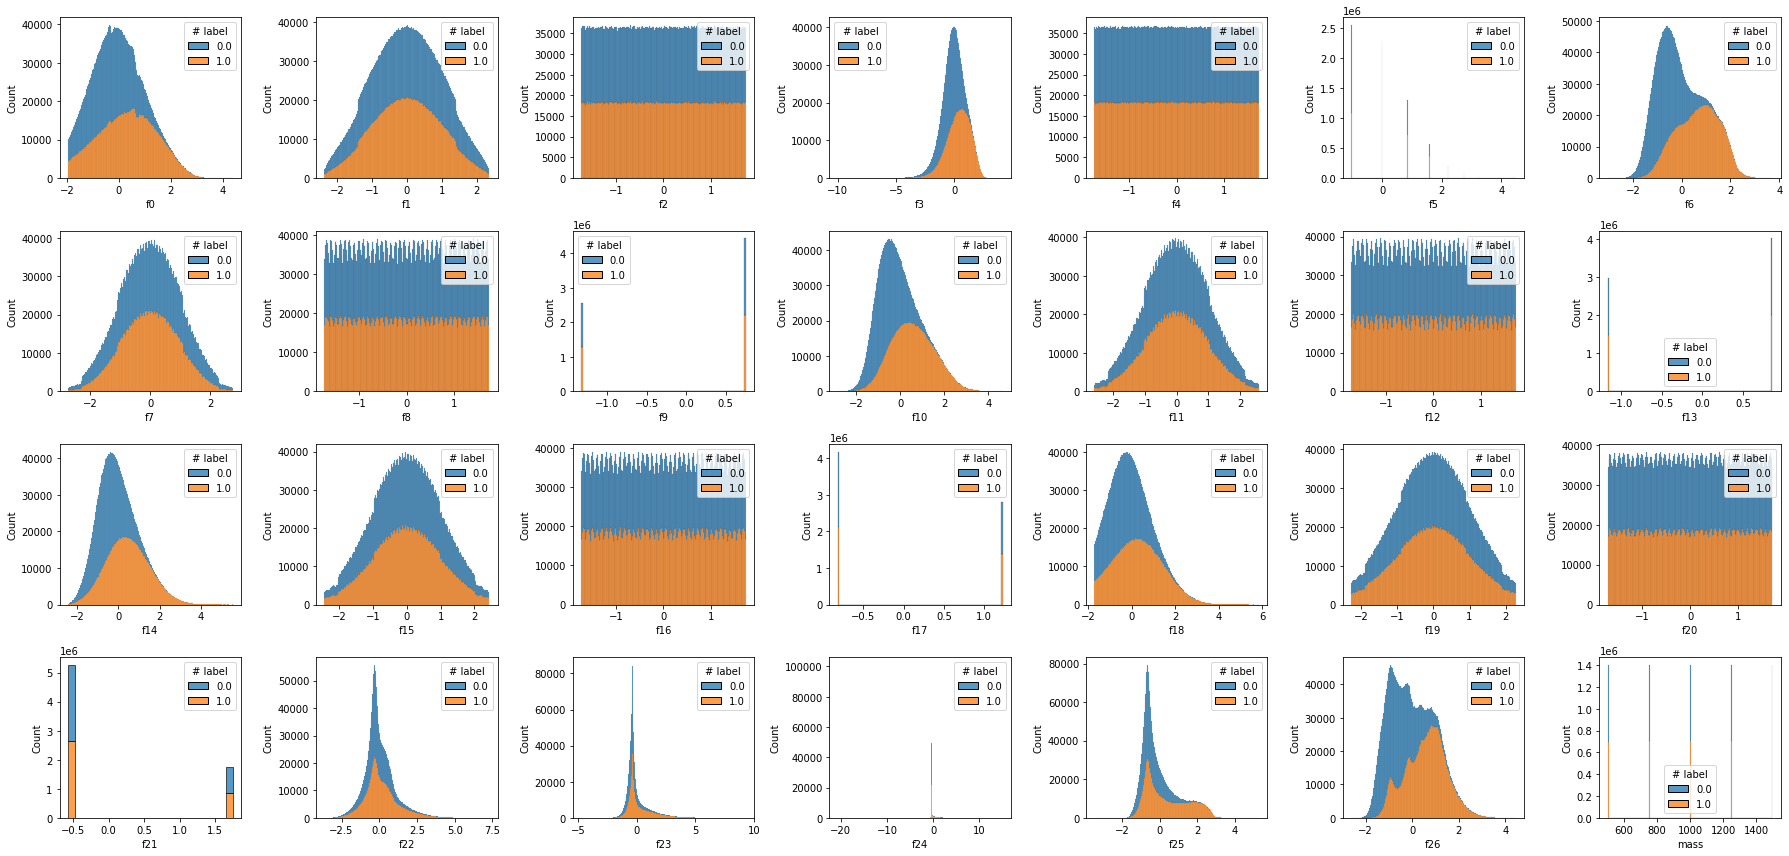

In [55]:
df_features = df.copy()
df_features.drop(["# label"], axis=1, inplace=True)

fig,axs = plt.subplots(4,7, figsize = (25,12))
h, v = 0, 0
for i in df_features.columns:
    sns.histplot(data=df, x=i, hue='# label', multiple='stack', ax=axs[h, v])
    if v == 6:
        h += 1
        v = -1
    v += 1
fig.tight_layout()


IndexError: index 3 is out of bounds for axis 0 with size 3

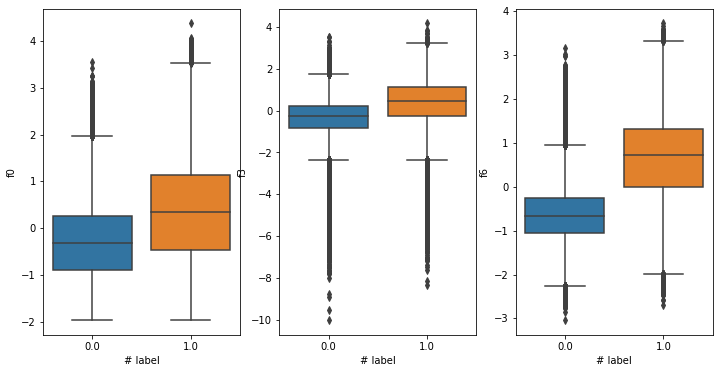

In [74]:
fig,axs = plt.subplots(1, 3, figsize = (12, 6))

sns.boxplot(data=df, x='# label', y='f0', ax=axs[0])
sns.boxplot(data=df, x='# label', y='f3', ax=axs[1])
sns.boxplot(data=df, x='# label', y='f6', ax=axs[2])
sns.boxplot(data=df, x='# label', y='f10', ax=axs[3])
sns.boxplot(data=df, x='# label', y='f14', ax=axs[4])
sns.boxplot(data=df, x='# label', y='f18', ax=axs[5])
sns.boxplot(data=df, x='# label', y='f26', ax=axs[6])

fig.tight_layout()

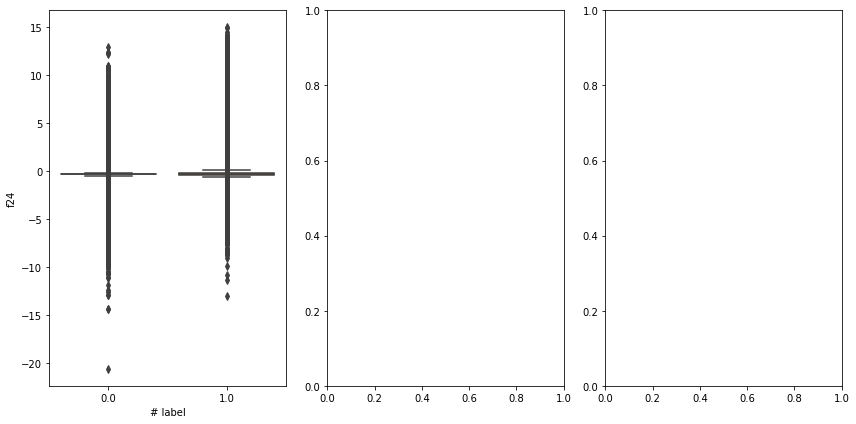

In [73]:
fig,axs = plt.subplots(1, 3, figsize = (12, 6))

sns.boxplot(data=df, x='# label', y='f24', ax=axs[0])

fig.tight_layout()

Overall, nothing really strongly correlates to each other.  Correlation value is within only (-.3, .3)

<AxesSubplot:>

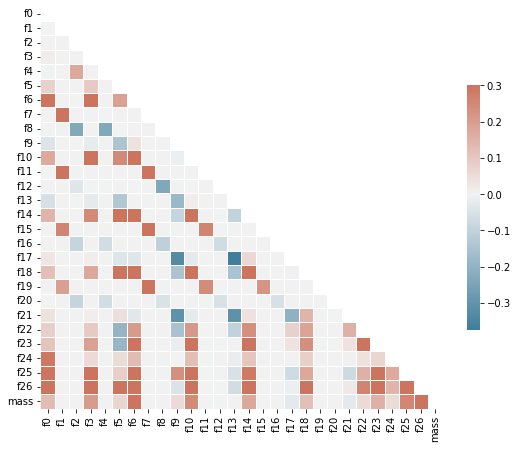

In [57]:
# Get correlation
corr = df_features.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(9, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})

## Modeling Preparations 

Dense neural networking models a appropriate for the problem becasue interpability is not a requirement and the dataset is 7 million rows, consisting of prodominetly continuous values.<br>
Also, per the objective of the assignment a Neural Network was requested and the data was deemed suitbale for the problem.<br>
To dfferentiate the usefullness of competing models the accuracy metric, since the target values are balanced, loss and model complexity were considered.<br>

### Train Test Split

In [58]:
from sklearn.model_selection import train_test_split

model_data = df.copy()

feature_data = model_data.copy()
feature_data.drop(["# label"], axis=1, inplace=True)

target_data = model_data['# label']

# Splitted train and test dataset
X_train, X_test, y_train, y_test = train_test_split(feature_data,target_data,test_size=0.10,random_state=0)

print("Size of modeling set (to be CV split): ", X_train.shape)
print(y_train.value_counts())
print(y_train.value_counts(normalize=True))
print("Size of hold back validation set: ", X_test.shape)
print(y_test.value_counts())
print(y_test.value_counts(normalize=True))

Size of modeling set (to be CV split):  (6300000, 28)
1.0    3150462
0.0    3149538
Name: # label, dtype: int64
1.0    0.500073
0.0    0.499927
Name: # label, dtype: float64
Size of hold back validation set:  (700000, 28)
1.0    350417
0.0    349583
Name: # label, dtype: int64
1.0    0.500596
0.0    0.499404
Name: # label, dtype: float64


### Fit & Transform

In [59]:
#Scale new predictor matrix
from sklearn.preprocessing import StandardScaler

scl_obj = StandardScaler()
scl_obj.fit(X_train)
X_train_ = scl_obj.transform(X_train)

scl_obj.fit(X_test)
X_test_ = scl_obj.transform(X_test)

### Set & Check Tensor Flow Configs

In [60]:
# TensorFlow and tf.keras
import tensorflow as tf
tf.random.set_seed(1234)

print(tf.__version__)

2.9.1


## Model Builing & Evaluation

Six models were built and evaluated, and with each proceeding model more complexity was introduced in efforts to improve the models performance. <br>
Adding more complexity to improve model performance does put your model at risk of overfitting.<br>
Overfitting was addressed during the model building phase by using regularization and drop layers. <br>
During the evaluatin phase overfitting was accounted for by evaluating the models accuracy and loss for the hold out set.<br>

### Metric Functions

In [61]:
import keras.backend as K

# define metrics
def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [62]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
# This callback will stop the training when there is no improvement in the loss for three consecutive epochs.


def compile_and_fit(model, model_name, history_dict, test_df):

    # Compile and fit model
    model.compile(loss='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy', F1])
    
    model_ = model.fit(X_train_, y_train, validation_split=0.1, epochs=100, batch_size=10000, verbose=0, callbacks=[callback])

    # Evaluate model
    e = model.evaluate(X_test_, y_test, batch_size=10000)

    # Add model name to evaluation object
    e.insert(0, model_name)

    # Convert eval into a df
    test_m = pd.DataFrame([e])
    test_m.columns = ['model','loss','acc','f1']

    # Get model history
    history = model_.history

    # Add model history to the history dictionary
    history_dict[model_name] = history

    # Concat test matrix to the test df
    test_df = pd.concat([test_df, test_m])

    return model_.history, test_m, history_dict, test_df



In [63]:
models_histories = {}
test_matrices = pd.DataFrame()

In [64]:
# Model 1
model1 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                      
])  

h, t, _, _ = compile_and_fit(model1, 'Model 1', models_histories, test_matrices)


70/70 [==============================] - 0s 4ms/step - loss: 0.2807 - accuracy: 0.8713 - F1: 0.8751


In [65]:
# Model 2
model2 = tf.keras.Sequential([
    tf.keras.layers.Dense(32, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t, _, _ = compile_and_fit(model2, 'Model 2', models_histories, test_matrices)

70/70 [==============================] - 0s 5ms/step - loss: 0.2692 - accuracy: 0.8780 - F1: 0.8812


In [66]:
# Model 3
model3 = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(16, activation = 'relu'),
    tf.keras.layers.Dense(8, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t, _, _ = compile_and_fit(model3, 'Model 3', models_histories, test_matrices)
models_histories['Model 3'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 1s 7ms/step - loss: 0.2614 - accuracy: 0.8820 - F1: 0.8844


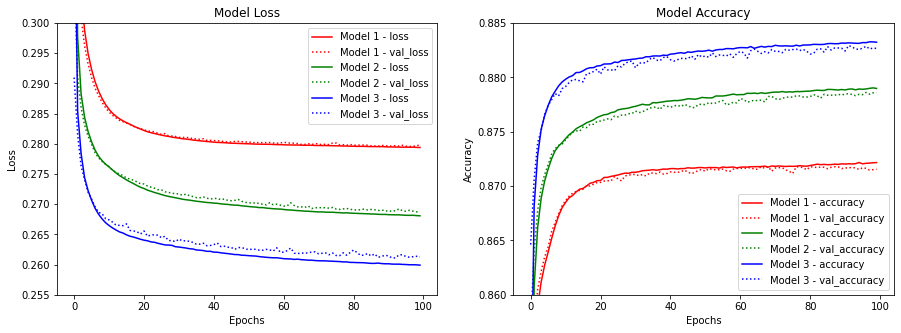

In [67]:
# plot
loss = ['loss', 'val_loss']
acc = ['accuracy', 'val_accuracy']
colors = ['red', 'green', 'blue']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## model1_    
ax[0].set(title="Model Loss")     
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')
ax[0].set_ylim(0.255, 0.3)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for l in loss:
        if "val" in l: 
            line='dotted'
        else:
            line='solid'
        ax[0].plot(models_histories[m][l], label=m+' - '+l, linestyle=line, color=c)
ax[0].legend()


ax[1].set(title="Model Accuracy")     
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Accuracy', color='black')
ax[1].set_ylim(0.86, 0.885)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for a in acc:
        if "val" in a: 
            line='dotted'
        else:
            line='solid'
        ax[1].plot(models_histories[m][a], label=m+' - '+a, linestyle=line, color=c)
ax[1].legend()
        

---
## Models 4 & 5

In [68]:
# Model 4
model4 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01),),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

h, t, _, _ = compile_and_fit(model4, 'Model 4', models_histories, test_matrices)
models_histories['Model 4'] = h
test_matrices = pd.concat([test_matrices, t])

70/70 [==============================] - 1s 7ms/step - loss: 0.2715 - accuracy: 0.8784 - F1: 0.8826


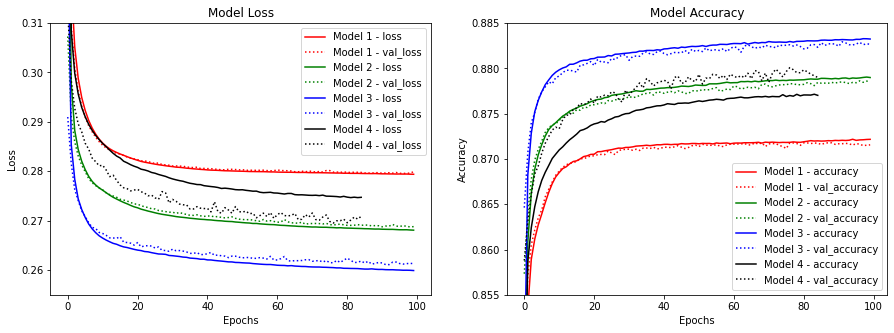

In [69]:
# plot
loss = ['loss', 'val_loss']
acc = ['accuracy', 'val_accuracy']
colors = ['red', 'green', 'blue', 'black']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## model1_    
ax[0].set(title="Model Loss")     
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')
ax[0].set_ylim(0.255, 0.31)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for l in loss:
        if "val" in l: 
            line='dotted'
        else:
            line='solid'
        ax[0].plot(models_histories[m][l], label=m+' - '+l, linestyle=line, color=c)
ax[0].legend()


ax[1].set(title="Model Accuracy")     
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Accuracy', color='black')
ax[1].set_ylim(0.855, 0.885)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for a in acc:
        if "val" in a: 
            line='dotted'
        else:
            line='solid'
        ax[1].plot(models_histories[m][a], label=m+' - '+a, linestyle=line, color=c)
ax[1].legend()
        

In [70]:
# Model 5
model5 = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation = 'relu', input_shape=(X_train_.shape[1], )),
    tf.keras.layers.Dense(32, activation = 'relu'),
    tf.keras.layers.Dense(1, activation = 'sigmoid')                       
])

h, t, _, _ = compile_and_fit(model5, 'Model 5', models_histories, test_matrices)

70/70 [==============================] - 1s 7ms/step - loss: 0.2617 - accuracy: 0.8821 - F1: 0.8840


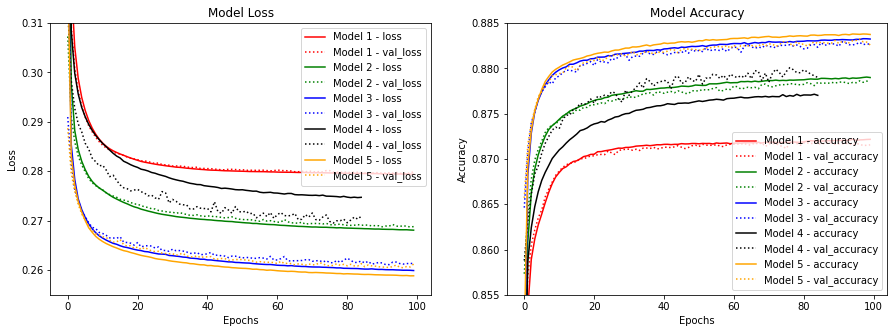

In [71]:
# plot
loss = ['loss', 'val_loss']
acc = ['accuracy', 'val_accuracy']
colors = ['red', 'green', 'blue', 'black', 'orange']
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15,5))

## model1_    
ax[0].set(title="Model Loss")     
ax[0].set_xlabel('Epochs')    
ax[0].set_ylabel('Loss', color='black')
ax[0].set_ylim(0.255, 0.31)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for l in loss:
        if "val" in l: 
            line='dotted'
        else:
            line='solid'
        ax[0].plot(models_histories[m][l], label=m+' - '+l, linestyle=line, color=c)
ax[0].legend()


ax[1].set(title="Model Accuracy")     
ax[1].set_xlabel('Epochs')    
ax[1].set_ylabel('Accuracy', color='black')
ax[1].set_ylim(0.855, 0.885)
for m, c in zip(models_histories, colors):
    # ax[0].plot(models_histories[m]['val_accuracy'], color=c)
    for a in acc:
        if "val" in a: 
            line='dotted'
        else:
            line='solid'
        ax[1].plot(models_histories[m][a], label=m+' - '+a, linestyle=line, color=c)
ax[1].legend()
        

In [72]:
# # Model 6
# model6 = tf.keras.Sequential([
#     tf.keras.layers.Dense(128, activation = 'relu', input_shape=(X_train_.shape[1], )),
#     tf.keras.layers.Dropout(0.2),
#     tf.keras.layers.Dense(32, activation = 'relu', kernel_regularizer=tf.keras.regularizers.l2(0.01),),
#     tf.keras.layers.Dense(1, activation = 'sigmoid')
# ])

# h, t, _, _ = compile_and_fit(model6, 'Model 6', models_histories, test_matrices)